In [1]:
%load_ext autoreload
%autoreload 2

In [205]:
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix, csr_matrix, vstack
import copy
import os
import helper
from wl import *
from joblib import Parallel, delayed
from time import time
import matplotlib.pyplot as plt
from glob import glob
import math
import pandas as pd
import collections

In [200]:
GRAPH_DIR = 'data/ng-20-single-document'
ORIGINAL_DOCUMENTS_DIR = 'extract-concept-graphs/code/data/ng20__single/train'

In [263]:
def flatten(l, as_set = False):
    return functools.reduce(lambda acc, x: acc | set(x) if as_set else acc + list(x), l, set() if as_set else list())

## Retrieve graphs from Tobias' concept-graph extraction library

In [242]:
def get_graphs(directory, ext = 'gml', undirected = False, verbose = False):
    graphs = {}
    empty_graphs = []
    files = sorted(glob(directory + '/*' + ext))
    graph_ids = []
    for idx, graph_file in helper.log_progress(list(enumerate(files)), every = 100):
        topic_and_id = graph_file.split('/')[-1].replace('.gml', '')
        
        topic = topic_and_id.split('_')[0]
        if topic not in graphs:
            graphs[topic] = []
        with open(graph_file) as f:
            graph = f.read().split('\n')
        for idx, line in enumerate(graph):
            if line.startswith('label'):
                next_line = graph[idx + 1]
                label = next_line.replace('name', 'label')
                graph[idx] = label
        try:
            graph = nx.parse_gml(graph)
            if undirected:
                graph = graph.to_undirected()
            #graph = nx.read_gml(new_graph_file, label = 'label')
            if graph.number_of_nodes() > 0 and graph.number_of_edges() > 0:
                graphs[topic].append(graph)
                graph_ids.append(topic_and_id)
            else:
                empty_graphs.append(topic_and_id)
                if verbose: print("Found empty graph: {}".format(graph_file))
        except nx.NetworkXError as e:
            if verbose: print('Exception ({}): {}'.format(graph_file, e))
    if verbose: print('Found empty graphs: {}'.format(len(empty_graphs)))
    return graphs, empty_graphs, graph_ids

graphs_per_topic, empty_graphs, graph_ids = get_graphs(GRAPH_DIR, undirected = False, verbose = False)

Widget Javascript not detected.  It may not be installed or enabled properly.


## Retrieve original documents

In [243]:
def get_original_documents(DIR, ext = '/*/*.txt', whitelist = (), verbose = False):
    topics = collections.defaultdict(lambda: [])
    for file in helper.log_progress(list(sorted(glob(DIR + ext))), every = 100):
        topic_and_id = file.split('/')[-2]
        topic = topic_and_id.split('_')[0]
        if topic_and_id not in whitelist:
            if verbose: print('Ignoring: {} (not in whitelist)'.format(topic_and_id))
            continue
        with open(file) as f:
            topics[topic].append(f.read())
    return topics
docs_per_topic = get_original_documents(ORIGINAL_DOCUMENTS_DIR, whitelist = graph_ids)

Widget Javascript not detected.  It may not be installed or enabled properly.


#docs:		14710
#graphs:	14710


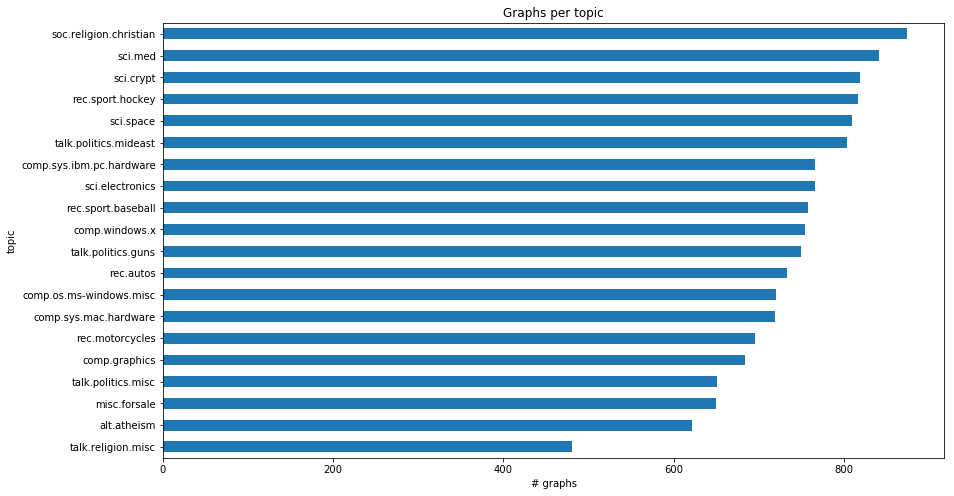

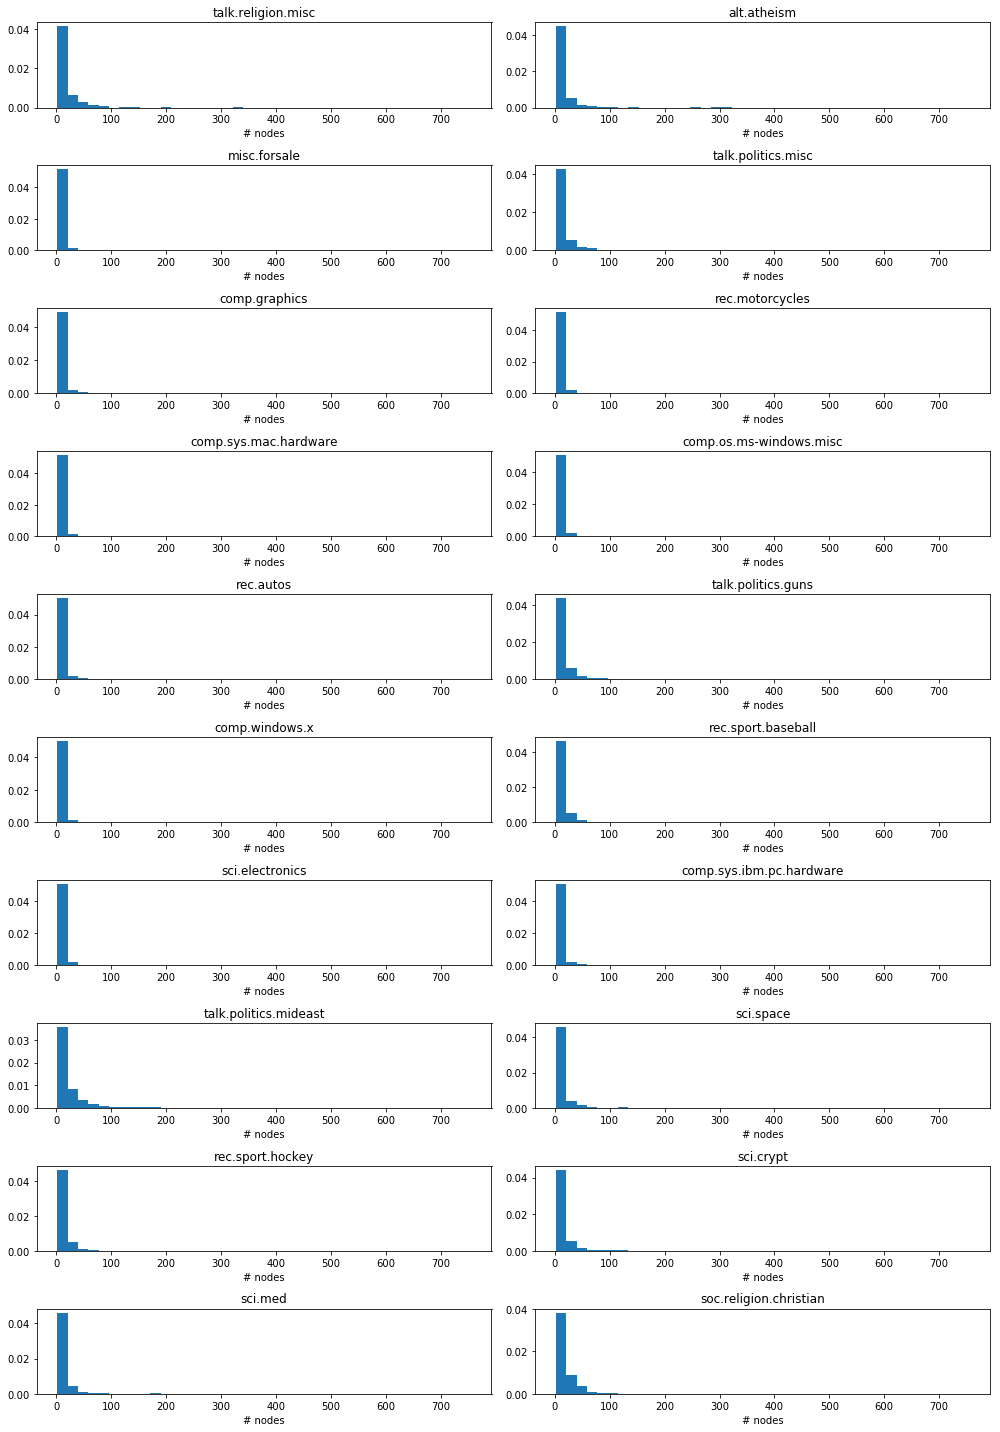

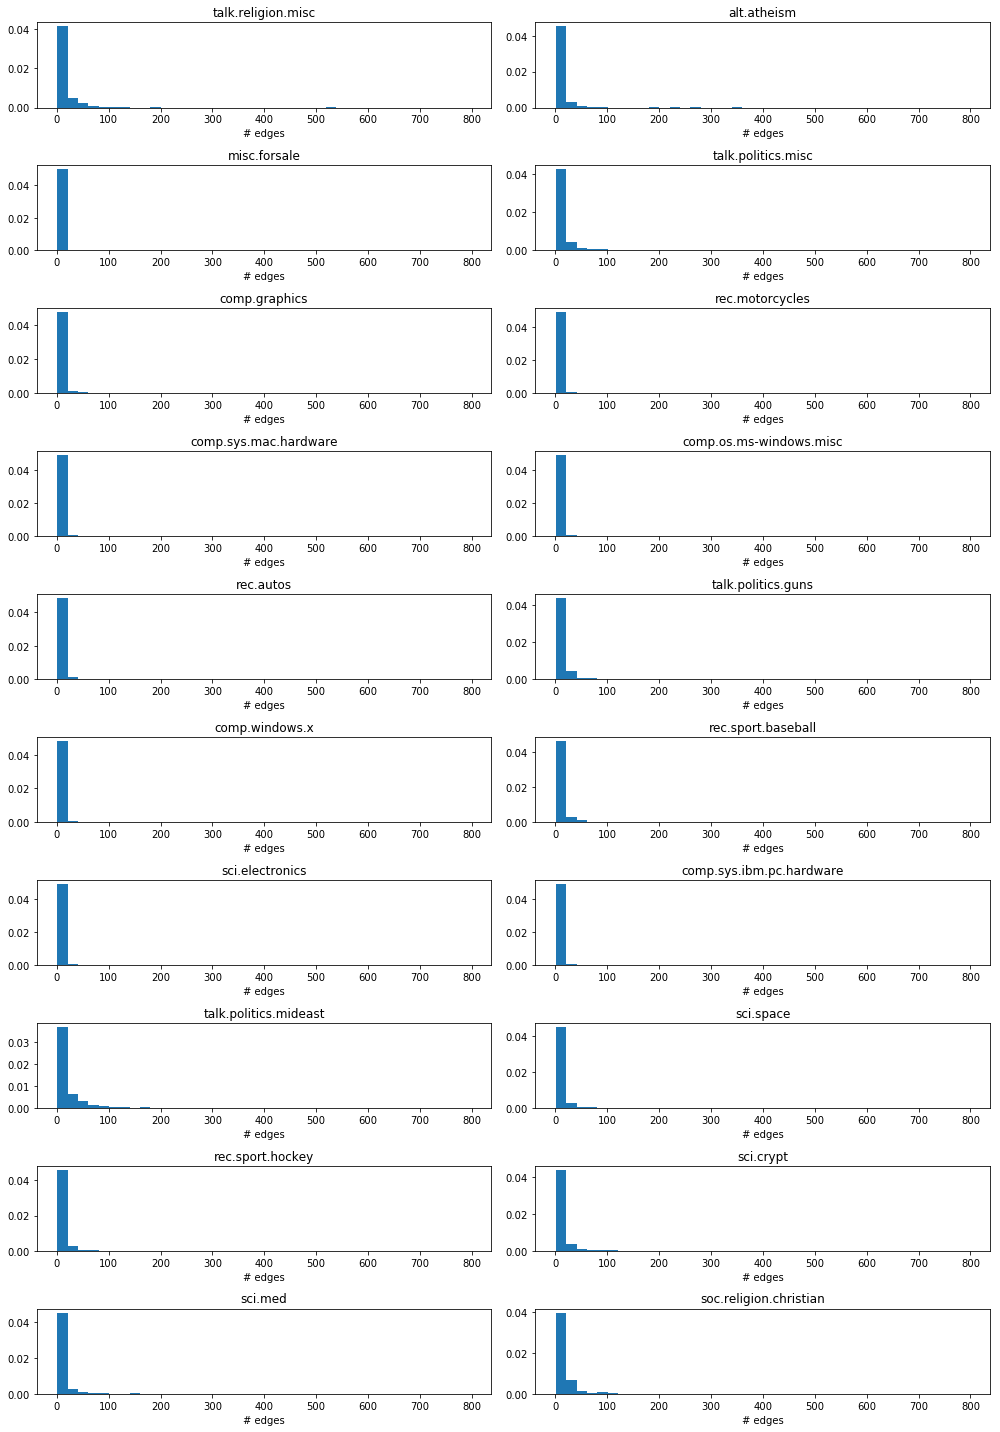

In [199]:
graphs_per_topic = pd.DataFrame([(topic, len(graphs), [len(x.nodes()) for x in graphs], [len(x.edges()) for x in graphs]) for topic, graphs in graphs_per_topic.items()], columns = ['topic', 'num_graphs', 'num_nodes', 'num_edges']).set_index(['topic']).sort_values(by = 'num_graphs')
ax = graphs_per_topic.plot.barh(title = 'Graphs per topic', legend = False, figsize = (14, 8))
ax.set_xlabel('# graphs')

def get_range_of(df, column):
    return df[column].apply(lambda x: min(x)).min(), df[column].apply(lambda x: max(x)).max()

nodes_range = get_range_of(graphs_per_topic, 'num_nodes')
edges_range = get_range_of(graphs_per_topic, 'num_edges')
plt.show()
ncols, nrows = (2, 10)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
fig_, axes_ = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
for idx, (topic, (num_graphs, num_nodes, num_edges)) in enumerate(graphs_per_topic.iterrows()):
    row = int(idx / ncols)
    col = idx % ncols
    ax = axes[row][col]
    ax_ = axes_[row][col]
    
    # 
    ax.set_title("{}".format(topic))
    ax.set_xlabel('# nodes')
    ax.hist(num_nodes, bins=40, normed = True, range = nodes_range)
    
    #
    ax_.set_title("{}".format(topic))
    ax_.set_xlabel('# edges')
    ax_.hist(num_edges, bins=40, normed = True, range = edges_range)
fig.tight_layout()
fig_.tight_layout()
plt.show()

In [274]:
REMOVE_CATEGORIES = ['misc.forsale']
graphs = graphs_per_topic.copy()
docs = docs_per_topic.copy()
if len(REMOVE_CATEGORIES):
    for cat in REMOVE_CATEGORIES:
        del graphs[cat]
        del docs[cat]

In [275]:
all_graphs = flatten(graphs.values())
all_docs = flatten(docs.values())

In [276]:
print('#docs:\t\t{}\n#graphs:\t{}'.format(len(all_docs), len(all_graphs)))
assert len(all_docs) == len(all_graphs)

#docs:		14060
#graphs:	14060


In [277]:
all_nodes = set()
for g in all_graphs:
    all_nodes |= set(g.nodes())
print('Unique tokens found: {}'.format(len(all_nodes)))
#123 068

Unique tokens found: 123068


## Some helper

In [68]:
def get_wl_for_graphs(graphs, all_nodes = all_nodes,  h = 10, fn = WL_compute):
    nodes = [sorted(g.nodes()) for g in graphs]
    adjs = [nx.adjacency_matrix(g, nodelist = sorted(g.nodes())).toarray() for g in graphs]
    return fn(adjs, nodes, all_nodes = all_nodes, h = h)

In [69]:
graphs_as_list = functools.reduce(lambda acc, x: acc + [(x[0], y) for y in x[1]], graphs.items(), [])
print('Graphs: {}'.format(len(graphs_as_list)))

def get_train_test_split(topic_graphs, train_split_ratio = 0.8):
    train = []
    test = []
    num_elements = {}
    for topic, graphs in topic_graphs.items():
        num_elements_train = int(len(graphs) * train_split_ratio)
        num_elements[topic] = num_elements_train
        train += [(topic, x) for x in graphs[:num_elements_train]]
        test += [(topic, x) for x in graphs[num_elements_train:]]
    return train, test, num_elements

train, test, num_elements = get_train_test_split(graphs)

Graphs: 14060


In [70]:
{topic: len(graphs) for topic, graphs in train}

{'alt.atheism': 7,
 'comp.graphics': 2,
 'comp.os.ms-windows.misc': 14,
 'comp.sys.ibm.pc.hardware': 11,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 2,
 'rec.autos': 89,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 16,
 'rec.sport.hockey': 7,
 'sci.crypt': 4,
 'sci.electronics': 17,
 'sci.med': 5,
 'sci.space': 2,
 'soc.religion.christian': 4,
 'talk.politics.guns': 4,
 'talk.politics.mideast': 7,
 'talk.politics.misc': 6,
 'talk.religion.misc': 13}

In [71]:
H = 2

## Calculate gram-matrix for WL kernel for the training concept-graphs

In [72]:
#%%time
from sklearn import svm
import psutil

adjs = []
nodes = []
for topic, graph in train:
    sorted_nodes = sorted(graph.nodes())
    adjs.append(nx.adjacency_matrix(graph, nodelist = sorted_nodes))
    nodes.append(sorted_nodes)

In [104]:
print('Calculating WL_train: start', psutil.virtual_memory())
K_train, phi_list_train, label_lookup_train, label_counters_train = WL_compute(adjs, nodes, H, all_nodes = all_nodes, DEBUG = True, compute_k = False)
print('Calculating WL_train: end', psutil.virtual_memory())

Calculating WL_train: start svmem(total=8589934592, available=2813538304, percent=67.2, used=5482065920, free=2499584000, active=3574566912, inactive=313954304, wired=1593544704)
Number of original labels 123112
K original is computed
Iteration 0: phi is computed
	Graph          0/11240
	Graph       1000/11240
	Graph       2000/11240
	Graph       3000/11240
	Graph       4000/11240
	Graph       5000/11240
	Graph       6000/11240
	Graph       7000/11240
	Graph       8000/11240
	Graph       9000/11240
	Graph      10000/11240
	Graph      11000/11240
Number of compressed labels 124908
Itaration 0: phi computed
Iteration 1: phi is computed
	Graph          0/11240
	Graph       1000/11240
	Graph       2000/11240
	Graph       3000/11240
	Graph       4000/11240
	Graph       5000/11240
	Graph       6000/11240
	Graph       7000/11240
	Graph       8000/11240
	Graph       9000/11240
	Graph      10000/11240
	Graph      11000/11240
Number of compressed labels 125207
Itaration 1: phi computed
Calculati

## Train SVM classifier on the gram-matrix

In [105]:
import sklearn
#clf = svm.SVC(kernel = 'precomputed', verbose = True, probability=True)
clf = sklearn.linear_model.Perceptron(n_iter = 100, verbose = True, n_jobs = -1)

'''
batches = 100
num_elements_per_batch = int(len(train) / 10)
for start in range(batches):
    start = start * num_elements_per_batch
    end = min(len(train), start +
              num_elements_per_batch)
    print('Iteration: {}, #Elements: {}'.format(start, end - start))
    if end - start == 0:
        break
'''
X = phi_list_train[-1].T
Y = [topic for topic, graphs in train]
clf.fit(X, Y)


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1







Norm: 112.69, NNZs: 12605, Bias: -0.090000, T: 11240, Avg. loss: 0.042233Norm: 101.31, NNZs: 10225, Bias: -0.010000, T: 11240, Avg. loss: 0.025264Norm: 90.10, NNZs: 8097, Bias: -0.020000, T: 11240, Avg. loss: 0.019456Norm: 101.20, NNZs: 10211, Bias: -0.010000, T: 11240, Avg. loss: 0.025030Norm: 103.68, NNZs: 10693, Bias: -0.010000, T: 11240, Avg. loss: 0.020717Norm: 105.55, NNZs: 11108, Bias: -0.040000, T: 11240, Avg. loss: 0.027997Norm: 104.29, NNZs: 10835, Bias: -0.020000, T: 11240, Avg. loss: 0.024833Norm: 101.27, NNZs: 10228, Bias: 0.000000, T: 11240, Avg. loss: 0.021972







Total training time: 0.02 seconds.Total training time: 0.02 seconds.Total training time: 0.02 seconds.Total training time: 0.02 seconds.Total training time: 0.01 seconds.Total training time: 0.02 seconds.Total training time: 0.02 seconds.Total training time: 0.02 seconds.







-- Epoch 2-- Epoch 2-- Epoch 2-- Epoch 2-- 

-- Epoch 18-- Epoch 18-- Epoch 18-- Epoch 18


-- Epoch 18



Norm: 122.43, NNZs: 14837, Bias: -0.930000, T: 202320, Avg. loss: 0.002860Norm: 107.75, NNZs: 11544, Bias: -0.680000, T: 202320, Avg. loss: 0.003138Norm: 97.83, NNZs: 9535, Bias: -0.470000, T: 202320, Avg. loss: 0.001399
Norm: 111.62, NNZs: 12360, Bias: -0.550000, T: 202320, Avg. loss: 0.001479Norm: 109.96, NNZs: 12047, Bias: -0.370000, T: 202320, Avg. loss: 0.001851Norm: 110.45, NNZs: 12131, Bias: -0.530000, T: 202320, Avg. loss: 0.001753Norm: 108.23, NNZs: 11663, Bias: -0.520000, T: 202320, Avg. loss: 0.001646


Norm: 108.06, NNZs: 11617, Bias: -0.630000, T: 202320, Avg. loss: 0.003221



Total training time: 0.29 seconds.Total training time: 0.28 seconds.Total training time: 0.28 seconds.
Total training time: 0.29 seconds.Total training time: 0.30 seconds.Total training time: 0.29 seconds.Total training time: 0.30 seconds.


Total training time: 0.32 seconds.



-- Epoch 19-- Epoch 19-- Epoch 19
-- Epoch 19-- Epoch 19-- E

Total training time: 0.78 seconds.Total training time: 0.77 seconds.Total training time: 0.80 seconds.Total training time: 0.77 seconds.Total training time: 0.77 seconds.

Total training time: 0.78 seconds.




-- Epoch 49-- Epoch 49
-- Epoch 49-- Epoch 49-- Epoch 49-- Epoch 49-- Epoch 49

-- Epoch 49




Norm: 107.82, NNZs: 11558, Bias: -0.670000, T: 550760, Avg. loss: 0.001952Norm: 97.83, NNZs: 9535, Bias: -0.470000, T: 550760, Avg. loss: 0.000514
Norm: 111.62, NNZs: 12360, Bias: -0.550000, T: 550760, Avg. loss: 0.000543Norm: 109.96, NNZs: 12047, Bias: -0.370000, T: 550760, Avg. loss: 0.000680Norm: 110.45, NNZs: 12131, Bias: -0.530000, T: 550760, Avg. loss: 0.000644Norm: 108.23, NNZs: 11663, Bias: -0.520000, T: 550760, Avg. loss: 0.000605Norm: 122.43, NNZs: 14837, Bias: -0.930000, T: 550760, Avg. loss: 0.001051

Norm: 108.06, NNZs: 11616, Bias: -0.630000, T: 550760, Avg. loss: 0.002029




Total training time: 0.76 seconds.Total training time: 0.79 seconds.
Total training time: 0.80 

-- Epoch 42





Norm: 125.73, NNZs: 15663, Bias: -0.700000, T: 472080, Avg. loss: 0.001024
Norm: 108.51, NNZs: 11720, Bias: -0.460000, T: 472080, Avg. loss: 0.000955Norm: 110.57, NNZs: 12077, Bias: -0.610000, T: 472080, Avg. loss: 0.001127Norm: 134.11, NNZs: 17641, Bias: -1.000000, T: 472080, Avg. loss: 0.001740Norm: 151.79, NNZs: 22406, Bias: -1.020000, T: 472080, Avg. loss: 0.001804Norm: 129.70, NNZs: 16457, Bias: -1.000000, T: 472080, Avg. loss: 0.001263Norm: 114.47, NNZs: 12970, Bias: -0.780000, T: 472080, Avg. loss: 0.001166
Norm: 133.48, NNZs: 17477, Bias: -1.000000, T: 472080, Avg. loss: 0.001605





Total training time: 0.75 seconds.
Total training time: 0.73 seconds.Total training time: 0.66 seconds.Total training time: 0.75 seconds.Total training time: 0.67 seconds.Total training time: 0.67 seconds.Total training time: 0.68 seconds.
Total training time: 0.66 seconds.





-- Epoch 43
-- Epoch 43-- Epoch 43-- Epoch 43-- Epoch 43-- Epoch 43-- Epoch 43
-- Epoch 43





Norm: 1

[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.0s finished


Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=100, n_jobs=-1, penalty=None, random_state=0, shuffle=True,
      verbose=True, warm_start=False)



-- Epoch 74
-- Epoch 74-- Epoch 74-- Epoch 74-- Epoch 74-- Epoch 74-- Epoch 74
-- Epoch 74





Norm: 125.73, NNZs: 15663, Bias: -0.700000, T: 831760, Avg. loss: 0.000581
Norm: 108.51, NNZs: 11720, Bias: -0.460000, T: 831760, Avg. loss: 0.000688Norm: 110.58, NNZs: 12081, Bias: -0.600000, T: 831760, Avg. loss: 0.000746Norm: 134.11, NNZs: 17641, Bias: -1.000000, T: 831760, Avg. loss: 0.000987Norm: 151.79, NNZs: 22406, Bias: -1.020000, T: 831760, Avg. loss: 0.001024Norm: 129.70, NNZs: 16457, Bias: -1.000000, T: 831760, Avg. loss: 0.000717Norm: 114.46, NNZs: 12966, Bias: -0.790000, T: 831760, Avg. loss: 0.000772
Norm: 133.48, NNZs: 17477, Bias: -1.000000, T: 831760, Avg. loss: 0.001016





Total training time: 1.26 seconds.
Total training time: 1.26 seconds.Total training time: 1.17 seconds.Total training time: 1.27 seconds.Total training time: 1.17 seconds.Total training time: 1.19 seconds.Total training time: 1.20 seconds.
Total training time: 1.18 seconds.





-- Epoch 75
-- Epoch 7

In [107]:
def get_prediction(topic, graph):
    return compute_phi(graph, phi_list_train[0].shape, label_lookup_train, label_counters_train, h = H)[-1]

USED_SET = test
PARALLEL_PREDICTION_JOBS = 0
t = time()

if PARALLEL_PREDICTION_JOBS > 1:
    phi_test = Parallel(n_jobs=PARALLEL_PREDICTION_JOBS)(delayed(get_prediction)(*d) for d in list(USED_SET))
else:
    phi_test = [get_prediction(*d) for d in USED_SET]
print('Time: {:.2f}s'.format(time() - t, PARALLEL_PREDICTION_JOBS))

Time: 36.82s


In [108]:
import gc
gc.collect()

4531

In [109]:
%%time
def calculate_batches(l, fn, num_batches = 100):
    elements = []
    num_elements_per_batch = math.ceil(len(l) / num_batches)
    print('Starting: #elements: {}, #batches: {}, #elements per Batch: {}'.format(len(l), num_batches, num_elements_per_batch))
    for idx in range(num_batches):
        start = idx * num_elements_per_batch
        end = min(len(l), start + num_elements_per_batch)
        if idx % 10 == 0: print('\tIteration: {:>4}/{}'.format(idx, num_batches))
        if end - start <= 0:
            break
        elements += fn(l[start:end]).tolist()
    return elements
predicted = calculate_batches(phi_test, clf.predict)

Starting: #elements: 2820, #batches: 100, #elements per Batch: 29
	Iteration:    0/100
	Iteration:   10/100
	Iteration:   20/100
	Iteration:   30/100
	Iteration:   40/100
	Iteration:   50/100
	Iteration:   60/100
	Iteration:   70/100
	Iteration:   80/100
	Iteration:   90/100
CPU times: user 5.77 s, sys: 2.93 s, total: 8.7 s
Wall time: 8.84 s


In [110]:
Y_real = [topic for topic,graph in USED_SET]
Y_pred = predicted

sklearn.metrics.accuracy_score(Y_real, Y_pred), sklearn.metrics.f1_score(Y_real, Y_pred, average='macro')

(0.28191489361702127, 0.3089328164510981)

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball' 'rec.sport.hockey'
 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


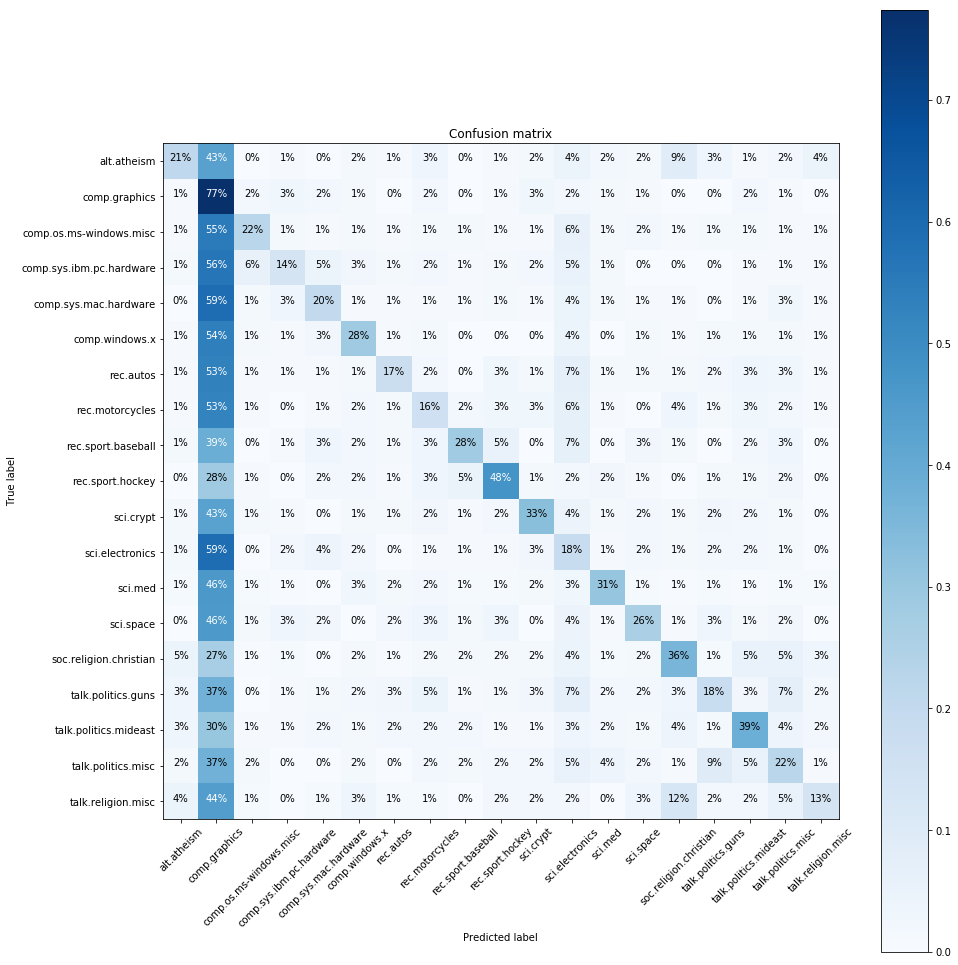

In [111]:
cf_mat = sklearn.metrics.confusion_matrix(Y_real, Y_pred)

fig = plt.figure(figsize=(14, 14))
helper.plot_confusion_matrix(cf_mat, clf.classes_, normalize = True)
plt.show()

In [112]:
import pickle

with open('data/graphs.npy', 'wb') as f:
    pickle.dump({
            'train': train,
            'test': test,
            'K_train': K_train,
            'phi_list_train': phi_list_train,
            'label_lookup_train': label_lookup_train,
            'label_counters_train': label_counters_train
    }, f)

## Test classifier

In [ ]:
%store all_graphs_test
%store all_graphs_train
%store K_train
%store phi_list_train
%store label_counters_train
%store label_lookup_train

## Draw graphs

In [ ]:
if 0 == 1:
    fig = plt.figure(figsize=(30, 30))
    pos=nx.spring_layout(g_mult_dir)
    nx.draw(g_mult_dir, pos = pos)

    edge_labels=dict([((u,v,),d['name'])
                 for u,v,d in g_mult_dir.edges(data=True)])
    nx.draw_networkx_edge_labels(g_mult_dir,pos,edge_labels=edge_labels)
    nx.draw_networkx_nodes(g_mult_dir, pos = pos, label='name', )
    nx.draw_networkx_labels(g_mult_dir, pos = pos)
    plt.show()

    graphs = sorted(list(nx.weakly_connected_component_subgraphs(g_mult_dir)), key = len)#, reverse = True)

    for graph in graphs[-4:]:
        fig = plt.figure(figsize=(20, 20))
        pos=nx.spring_layout(graph)
        #nx.draw(graph, pos = pos)
        edge_labels=dict([((u,v,),d['name'])
                     for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        nx.draw_networkx_edges(graph, pos, arrows = True)
        nx.draw_networkx_nodes(graph, pos = pos, label='name')
        nx.draw_networkx_labels(graph, pos = pos)
        plt.show()
